In [7]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

## Load image from skimage

In [8]:
img = data.astronaut()
[m,n] = img.shape[0:2]
n_pixels = m*n

## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder.

In [9]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,0.4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

## Load the matrix in the LocalGraphClustering API

In [10]:
g = GraphLocal()
g.from_sparse_adjacency(A)

## Find a single segment in the image using local graph clustering. Ignore warnings about weighted graphs.

/usr/local/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:119: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted or l1reg-rand instead if you want to keep the edge weights.



0.5536880493164062


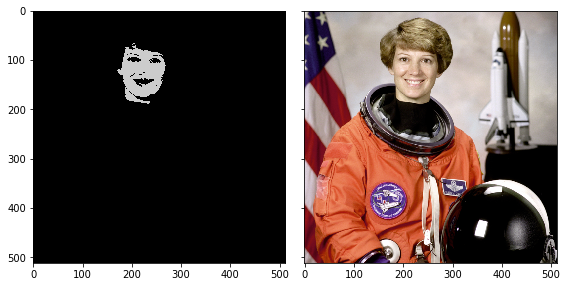

In [11]:
start = time.time()
refnode = [120*m + 220]
output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=0.03,rho=1.0e-15,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 
end = time.time()
print(end - start)

labels = np.zeros(n_pixels)
labels[output[0]] = 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(labels.reshape((m,n)), cmap='nipy_spectral')
ax[1].imshow(img)

#for a in ax:
    #a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral local graph clustering

In [12]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation(g,rho_list=[1.0e-15,1.0e-1],iterations=1000000,alpha=0.03,ratio=0.1,nsamples_from_rho=1,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

51.84589910507202ted:  90.12489318847656


## Plot

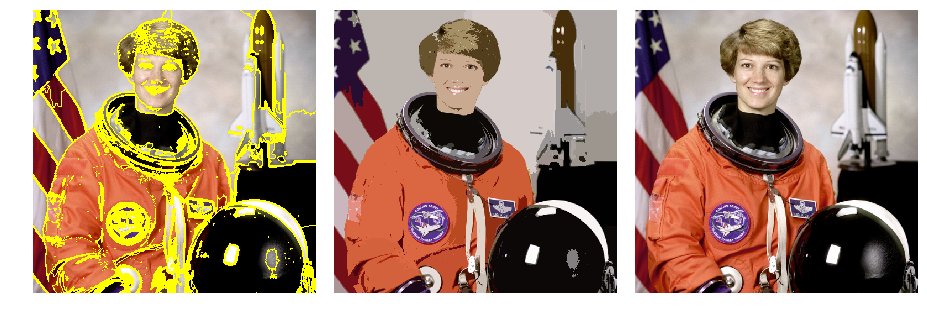

In [13]:
out_lgc = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral + flow (MQI) local graph clustering

In [23]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation_with_improve(g,rho_list=[1.0e-15,1.0e-1],iterations=1000000,alpha=0.03,ratio=0.1,nsamples_from_rho=1,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

119.3972761631012ted:  90.091705322265622


## Visualize the result

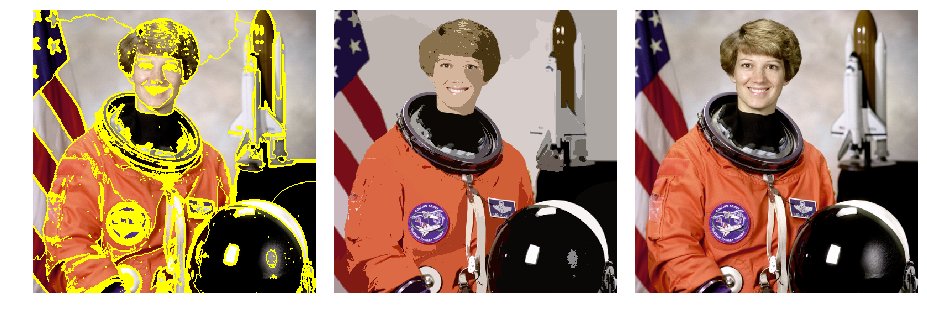

In [24]:
out_lgc_with_improve = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc_with_improve)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Run the classic normalized cut from skimage

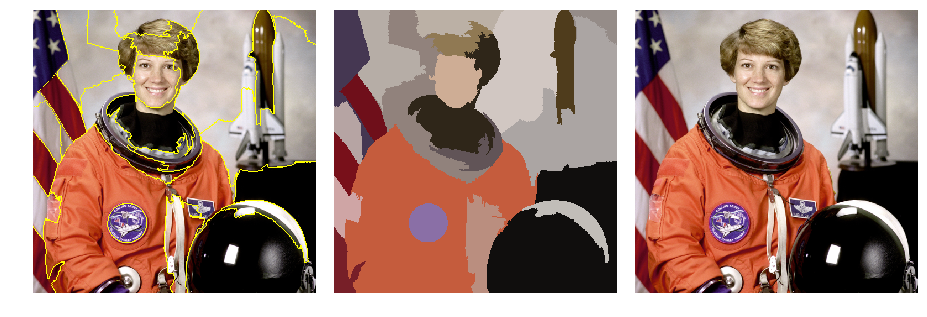

In [16]:
labels_slic = segmentation.slic(img, n_segments=100)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=0.001, num_cuts=10)
out_ncuts = color.label2rgb(new_labels_slic, img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(out_ncuts)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Slice image using slic from skimage

In [17]:
labels = segmentation.slic(img, compactness=30, n_segments=400)
out_slic = color.label2rgb(labels, img, kind='avg')

## Visualize all results

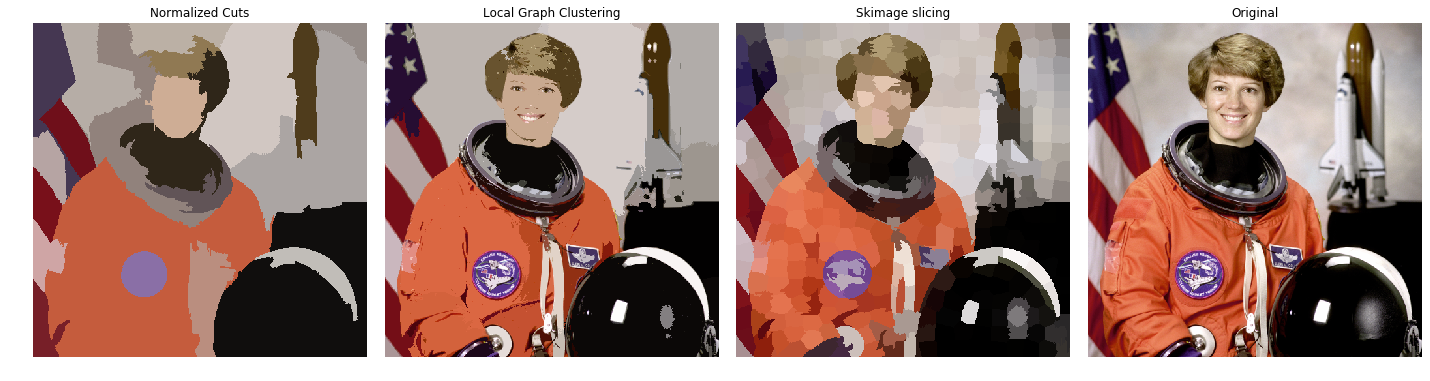

In [18]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(out_ncuts)
ax[1].imshow(out_lgc)
ax[2].imshow(out_slic)
ax[3].imshow(img)

ax[0].set_title('Normalized Cuts')
ax[1].set_title('Local Graph Clustering')
ax[2].set_title('Skimage slicing')
ax[3].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()